In [1]:
import glworia.amplification_factor
import glworia.lens_functions
from glworia.amplification_factor import *
from glworia.lens_functions import *
import glworia.lens_functions
from glworia.lens_functions import *
import glworia.contour
from glworia.contour import *
import glworia.utils
from glworia.utils import *
import glworia.root
from glworia.root import *
import glworia.plot
from glworia.plot import *
import glworia.frequency_domain
from glworia.frequency_domain import *

I0000 00:00:1705522662.778133 2969579 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
from importlib import reload

In [3]:
reload(glworia.amplification_factor)
reload(glworia.lens_functions)
from glworia.amplification_factor import *
from glworia.lens_functions import *
reload(glworia.lens_functions)
from glworia.lens_functions import *
reload(glworia.contour)
from glworia.contour import *
reload(glworia.utils)
from glworia.utils import *
reload(glworia.root)
from glworia.root import *
reload(glworia.plot)
from glworia.plot import *
reload(glworia.frequency_domain)
from glworia.frequency_domain import *

In [4]:
import matplotlib as mpl

plt.rc('text', usetex=False)
plt.rc('font', family='qpl')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['ytick.minor.size'] = 2

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.labeltop'] = plt.rcParams['ytick.labelright'] = False
mpl.rcParams['axes.unicode_minus'] = False

params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.size': 9,
          'legend.fontsize': 12,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'savefig.dpi': 200,
          'lines.markersize': 6,
          'axes.formatter.limits': (-3, 3)}

mpl.rcParams.update(params)

In [5]:
from jax.config import config
config.update("jax_enable_x64", True)

In [6]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [7]:
# use tex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# NFW profile

In [8]:
@jit
def Psi_NFW(x, lens_params):
    kappa = lens_params[0]
    x_norm = jnp.linalg.norm(x)
    dim_1 = jnp.ones(x.shape)
    x_safe_low = jnp.where(x_norm<1, x, 0.5*dim_1)
    x_safe_hi = jnp.where(x_norm<1, 2*dim_1, x)
    x_safe_low_norm = jnp.linalg.norm(x_safe_low)
    x_safe_hi_norm = jnp.linalg.norm(x_safe_hi)
    Psi = jnp.where(x_norm<1,
        kappa / 2 * (jnp.log(x_safe_low_norm/2)**2 - jnp.arctanh(jnp.sqrt(1-x_safe_low_norm**2))**2),
        kappa / 2 * (jnp.log(x_safe_hi_norm/2)**2 + jnp.arctan(jnp.sqrt(x_safe_hi_norm**2 - 1))**2))
    return Psi

In [9]:
T_funcs, helper_funcs = amplification_computation_prep(Psi_NFW)
crit_curve_helper_funcs = make_crit_curve_helper_func(T_funcs)

In [10]:
param_arr = jnp.linspace(0.1, 10., 100000)
crit_funcs = crtical_curve_interpolants(param_arr, T_funcs, crit_curve_helper_funcs)
crit_funcs_np = crtical_curve_interpolants_np(param_arr, T_funcs, crit_curve_helper_funcs)

In [11]:
crit_funcs_np

{'lens_param_to_x_crit': <scipy.interpolate._interpolate.interp1d at 0x1554a3864f40>,
 'lens_param_to_y_crit': <scipy.interpolate._interpolate.interp1d at 0x1554a387f360>,
 'x_crit_to_lens_param': <scipy.interpolate._interpolate.interp1d at 0x1554a3877310>,
 'y_crit_to_lens_param': <scipy.interpolate._interpolate.interp1d at 0x1554a3bb2cc0>,
 'y_crit_to_x_crit': <scipy.interpolate._interpolate.interp1d at 0x1554a3d3fef0>}

In [12]:
import pickle

with open('./interpolation/crit_funcs/NFW_crit_funcs_0.100_10.000.pkl', 'wb') as f:
    pickle.dump(crit_funcs_np, f)

In [13]:
N = 200
T0_max = 1000.
w_interp = jnp.linspace(1e-3, 1e3, 10**6)

In [14]:
y = jnp.array([0.2, 0.])
lens_params = jnp.array([5.0])
y_NFW_strong = y[0]
lp_NFW_strong = lens_params[0]
F_interp, F_interp_raw, contour_obj, partitions = compute_F(w_interp, y, lens_params, T_funcs, helper_funcs, crit_funcs,
              N, T0_max)
F_interp_NFW_strong = F_interp
contour_obj_NFW_strong = contour_obj
partitions_NFW_strong = partitions

In [15]:
y = jnp.array([1.0, 0.])
lens_params = jnp.array([3.0])
y_NFW_weak = y[0]
lp_NFW_weak = lens_params[0]
F_interp, F_interp_raw, contour_obj, partitions = compute_F(w_interp, y, lens_params, T_funcs, helper_funcs, crit_funcs,
              N, T0_max)
F_interp_NFW_weak = F_interp
contour_obj_NFW_weak = contour_obj
partitions_NFW_weak = partitions

# Generalized SIS profile

In [16]:
@jit
def Psi_gSIS(x, lens_params):
    k = lens_params[0]
    return jnp.linalg.norm(x)**(2 - k)/(2 - k)

In [17]:
def y_crit_override_gSIS(y_crit, lens_params):
    if lens_params[0] == 1.:
        return 1.
    elif lens_params[0] > 1.:
        return jnp.inf
    else:
        return y_crit

In [18]:
T_funcs, helper_funcs = amplification_computation_prep(Psi_gSIS)
crit_curve_helper_funcs = make_crit_curve_helper_func(T_funcs)

In [19]:
param_arr = jnp.linspace(0.1, 1.9, 100000)
crit_funcs = crtical_curve_interpolants(param_arr, T_funcs, crit_curve_helper_funcs)
crit_funcs_np = crtical_curve_interpolants_np(param_arr, T_funcs, crit_curve_helper_funcs)

with open('./interpolation/crit_funcs/gSIS_crit_funcs_0.100_1.900.pkl', 'wb') as f:
    pickle.dump(crit_funcs_np, f)

In [20]:
N = 200
T0_max = 1000.

In [21]:
bisection_1D_var_2D = make_bisection_1D_var_2D()
bisection_1D_cond_fun = make_bisection_1D_cond_fun(1e-13)
bisection_1D_step_fun = make_bisection_1D_step_fun(T_funcs["dT_1D"])

# @partial(jnp.vectorize, signature = '(3),(),()->(3)')
def x_im_nan_sub_gSIS(x_im, y0, lens_params):
    lens_params = jnp.atleast_1d(lens_params)
    x_im = jax.lax.cond(jnp.isnan(x_im[0]) & (lens_params[0] > 1.), 
                        lambda x_im: x_im.at[0].set(
                            bisection_1D_var_2D(T_funcs["dT_1D"], 0., 
                                                -0.1, -1e-14, 
                                                bisection_1D_cond_fun, 
                                                bisection_1D_step_fun, 
                                                y0, lens_params[0])
                        ), 
                        lambda x_im: x_im, 
                        operand = x_im)
    x_im = jax.lax.cond(jnp.isnan(x_im[1]) & (lens_params[0] < 1.), 
                        lambda x_im: x_im.at[1].set(
                            bisection_1D_var_2D(T_funcs["dT_1D"], 0., 
                                                -0.1, -1e-14, 
                                                bisection_1D_cond_fun, 
                                                bisection_1D_step_fun, 
                                                y0, lens_params[0])
                        ), 
                        lambda x_im: x_im, 
                        operand = x_im)
    return x_im

In [22]:
def origin_type_gSIS(lens_params):
    if lens_params[0] < 1.:
        origin = 'regular'
    else:
        origin = 'cusp'
    return origin

In [23]:
y =jnp.array([1.0, 0.])
lens_params = jnp.array([0.5])
y_gSIS_weak = y[0]
lp_gSIS_weak = lens_params[0]

F_interp, F_interp_raw, contour_obj, partitions = compute_F(w_interp, y, lens_params, T_funcs, helper_funcs, crit_funcs,
              N, T0_max, t_fft_long_max_fac = 5000, origin_type = origin_type_gSIS, y_crit_override = y_crit_override_gSIS,
              x_im_nan_sub = x_im_nan_sub_gSIS)
F_interp_gSIS_weak = F_interp
contour_obj_gSIS_weak = contour_obj
partitions_gSIS_weak = partitions

In [24]:
y =jnp.array([0.3, 0.])
lens_params = jnp.array([1.5])
y_gSIS_strong = y[0]
lp_gSIS_strong = lens_params[0]

F_interp, F_interp_raw, contour_obj, partitions = compute_F(w_interp, y, lens_params, T_funcs, helper_funcs, crit_funcs,
              N, T0_max, t_fft_long_max_fac = 5000, origin_type = origin_type_gSIS, y_crit_override = y_crit_override_gSIS,
              x_im_nan_sub = x_im_nan_sub_gSIS)
F_interp_gSIS_strong = F_interp
contour_obj_gSIS_strong = contour_obj
partitions_gSIS_strong = partitions

# cored SIS profile

In [25]:
@jit
def Psi_CIS(x, lens_params):
    x_c = jnp.abs(lens_params[0])
    x_t = jnp.sqrt(x_c**2 + jnp.linalg.norm(x)**2)
    x_c_safe = jnp.where(x_c > 1e-15, x_c, 1e-15)
    Psi = jnp.where(x_c > 1e-15, 
            x_t + x_c_safe * jnp.log(2 * x_c_safe / (x_t + x_c_safe)), 
            x_t
                    )
    return Psi

In [26]:
def y_crit_override_CIS(y_crit, lens_params):
    if lens_params[0] < 1e-15:
        return 1.
    else:
        return y_crit

In [27]:
def origin_type_CIS(lens_params):
    if jnp.abs(lens_params[0]) > 1e-15:
        origin = 'regular'
    else:
        origin = 'cusp'
    return origin

In [28]:
T_funcs, helper_funcs = amplification_computation_prep(Psi_CIS)
crit_curve_helper_funcs = make_crit_curve_helper_func(T_funcs)

In [29]:
add_indxs = jnp.where(param_arr < 1e-15)[0]
param_arr = param_arr[param_arr >= 1e-15]
crit_funcs = crtical_curve_interpolants(param_arr, T_funcs, crit_curve_helper_funcs, add_y = jnp.array([1.]), 
                                        add_x = jnp.array([0.]), add_param = jnp.array([0.]), add_indxs = add_indxs)

In [30]:
bisection_1D_var_2D = make_bisection_1D_var_2D()
bisection_1D_cond_fun = make_bisection_1D_cond_fun(1e-13)
bisection_1D_step_fun = make_bisection_1D_step_fun(T_funcs["dT_1D"])

# @partial(jnp.vectorize, signature = '(3),(),()->(3)')
def x_im_nan_sub_CIS(x_im, y0, lens_params):
    lens_params = jnp.atleast_1d(lens_params)
    x_im = jax.lax.cond(jnp.isnan(x_im[1]) & (lens_params[0] > 0) & (y0 < 1.),
                        lambda x_im: x_im.at[1].set(
                            bisection_1D_var_2D(T_funcs["dT_1D"], 0., 
                                                -0.1, -1e-14, 
                                                bisection_1D_cond_fun, 
                                                bisection_1D_step_fun, 
                                                y0, lens_params[0])
                        ), 
                        lambda x_im: x_im, 
                        operand = x_im)
    return x_im

In [31]:
y = jnp.array([1.5, 0.])
lens_params = jnp.array([0.2])
y_CIS_weak = y[0]
lp_CIS_weak = lens_params[0]
F_interp, F_interp_raw, contour_obj, partitions = compute_F(w_interp, y, lens_params, T_funcs, helper_funcs, crit_funcs,
              N, T0_max, origin_type = origin_type_CIS, x_im_nan_sub = x_im_nan_sub_CIS,
            #   y_crit_override = y_crit_override_CIS
              )
F_interp_CIS_weak = F_interp
contour_obj_CIS_weak = contour_obj
partitions_CIS_weak = partitions

In [32]:
y = jnp.array([0.2, 0.])
lens_params = jnp.array([0.05])
y_CIS_strong = y[0]
lp_CIS_strong = lens_params[0]
F_interp, F_interp_raw, contour_obj, partitions = compute_F(w_interp, y, lens_params, T_funcs, helper_funcs, crit_funcs,
              N, T0_max, origin_type = origin_type_CIS, x_im_nan_sub = x_im_nan_sub_CIS,
              # N_fft = 2**22,
            #   y_crit_override = y_crit_override_CIS
              )
F_interp_CIS_strong = F_interp
contour_obj_CIS_strong = contour_obj
partitions_CIS_strong = partitions

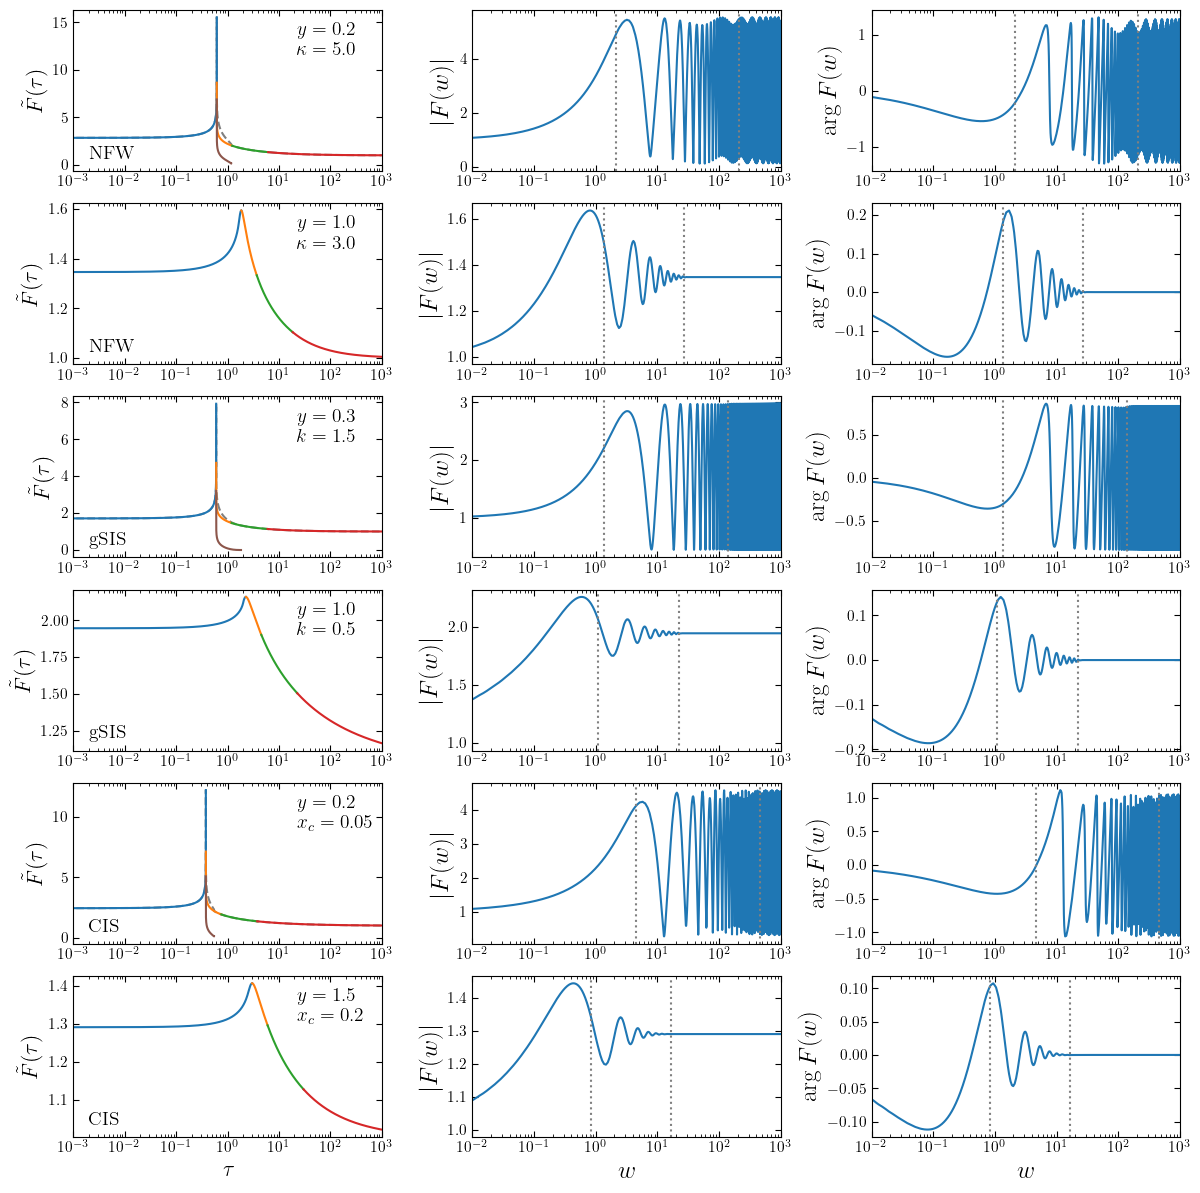

In [33]:
from scipy.interpolate import interp1d

fig, axs = plt.subplots(6, 3, figsize = (12, 12))

F_interps = [F_interp_NFW_strong, F_interp_NFW_weak,
             F_interp_gSIS_strong, F_interp_gSIS_weak, 
             F_interp_CIS_strong, F_interp_CIS_weak]

contour_objs = [contour_obj_NFW_strong, contour_obj_NFW_weak,
                contour_obj_gSIS_strong, contour_obj_gSIS_weak,
                contour_obj_CIS_strong, contour_obj_CIS_weak]

partitions = [partitions_NFW_strong, partitions_NFW_weak,
              partitions_gSIS_strong, partitions_gSIS_weak,
              partitions_CIS_strong, partitions_CIS_weak]

ys = [y_NFW_strong, y_NFW_weak,
        y_gSIS_strong, y_gSIS_weak,
        y_CIS_strong, y_CIS_weak]

lens_params = [lp_NFW_strong, lp_NFW_weak,
                lp_gSIS_strong, lp_gSIS_weak,
                lp_CIS_strong, lp_CIS_weak]

lens_models = ['NFW', 'NFW', 'gSIS', 'gSIS', 'CIS', 'CIS']

lp_name = ['\kappa', '\kappa', 'k', 'k', 'x_c', 'x_c']

for j, (contour_obj, ax) in enumerate(zip(contour_objs, axs[:, 0])):

    if j in [0, 2, 4]:
        T0_min_out_full = jnp.concatenate(contour_obj.T0_min_out_segments)
        u_min_out_full = jnp.concatenate(contour_obj.u_min_out)

        u_sad_max_proj_func = interp1d(contour_obj.T0_sad_max_segment, contour_obj.u_sad_max, kind = 'cubic',
                                            bounds_error = False, fill_value = 0.)
        u_sad_max_proj = u_sad_max_proj_func(T0_min_out_full)
        u_full = u_min_out_full + u_sad_max_proj

        ax.plot(T0_min_out_full, u_full, c = 'gray', ls = '--')

    for i in range(4):
        ax.plot(contour_obj.T0_min_out_segments[i],
                    contour_obj.u_min_out[i], c = f'C{i}')
    ax.plot(contour_obj.T0_sad_max_segment,
                contour_obj.u_sad_max, c = 'C5')
    ax.set_xscale('log')

    ax.set_ylabel(r'$\tilde{F}(\tau)$', fontsize = 16)
    ax.set_xlim([1e-3, 1e3])

    ax.text(0.725, 0.925, f'$y = {ys[j]}$\n${lp_name[j]} = {lens_params[j]}$', 
            transform = ax.transAxes, fontsize = 14, va = 'top', ha = 'left')
    ax.text(0.05, 0.05, lens_models[j],
            transform = ax.transAxes, fontsize = 14, va = 'bottom', ha = 'left')

for i in range(6):
    F_interp = F_interps[i]
    axs[i, 1].semilogx(w_interp, jnp.abs(F_interp))
    axs[i, 2].semilogx(w_interp, jnp.angle(F_interp))
    for partition in partitions[i]:
        if w_interp[0] < partition < w_interp[-1]:
            axs[i, 1].axvline(partition, color = 'gray', linestyle = ':')
            axs[i, 2].axvline(partition, color = 'gray', linestyle = ':')
    axs[i,1].set_xlim(1e-2, 1e3)
    axs[i,2].set_xlim(1e-2, 1e3)
    axs[i, 1].set_ylabel(r'$|F(w)|$')
    axs[i, 2].set_ylabel(r'$\arg F(w)$')

axs[5, 0].set_xlabel(r'$\tau$', fontsize = 16)
axs[5, 1].set_xlabel(r'$w$')
axs[5, 2].set_xlabel(r'$w$')

fig.tight_layout()

fig.savefig('./plots/amp_simple_plot.pdf', bbox_inches = 'tight')